In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

import sklearn 

import plotly
import plotly.express as px
import random

import tracemalloc

In [2]:
# for tracking memory usage
tracemalloc.start()

# Loading/Visualizing Data

In [3]:
# obtaining condition labels
labels_path = '../../data/medical_abstracts_TC_corpus/medical_tc_labels.csv'
df_labels = pd.read_csv(labels_path)
df_labels

,condition_label,condition_name
0,1,neoplasms
1,2,digestive system diseases
2,3,nervous system diseases
3,4,cardiovascular diseases
4,5,general pathological conditions


In [4]:
# might be useful for mapping and visualization
df_labels.to_dict(orient='list')

{'condition_label': [1, 2, 3, 4, 5],
 'condition_name': ['neoplasms',
  'digestive system diseases',
  'nervous system diseases',
  'cardiovascular diseases',
  'general pathological conditions']}

In [5]:
# loading training data
train_path = '../../data/medical_abstracts_TC_corpus/medical_tc_train.csv'
df_train = pd.read_csv(train_path)
df_train.head()

,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 0 to 11549
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   condition_label   11550 non-null  int64 
 1   medical_abstract  11550 non-null  object
dtypes: int64(1), object(1)
memory usage: 180.6+ KB


In [7]:
# loading test data
test_path = '../../data/medical_abstracts_TC_corpus/medical_tc_test.csv'
df_test = pd.read_csv(test_path)
df_test.head()

,condition_label,medical_abstract
0,3,Obstructive sleep apnea following topical orop...
1,5,Neutrophil function and pyogenic infections in...
2,5,A phase II study of combined methotrexate and ...
3,1,Flow cytometric DNA analysis of parathyroid tu...
4,4,Paraneoplastic vasculitic neuropathy: a treata...


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   condition_label   2888 non-null   int64 
 1   medical_abstract  2888 non-null   object
dtypes: int64(1), object(1)
memory usage: 45.3+ KB


In [9]:
# add new column saying whether the sample is test or train so I can use it as a mask later
df_train['test'] = False
df_test['test'] = True

df_all = pd.concat([df_train, df_test], axis=0).reset_index().drop('index', axis=1)
df_all.head()

,condition_label,medical_abstract,test
0,5,Tissue changes around loose prostheses. A cani...,False
1,1,Neuropeptide Y and neuron-specific enolase lev...,False
2,2,"Sexually transmitted diseases of the colon, re...",False
3,1,Lipolytic factors associated with murine and h...,False
4,3,Does carotid restenosis predict an increased r...,False


In [10]:
# adding condition name column for better visualization
df_all['condition_name'] = df_all['condition_label'].map(lambda x: df_labels[df_labels['condition_label'] == x].condition_name.item())

In [11]:
df_all.head()

,condition_label,medical_abstract,test,condition_name
0,5,Tissue changes around loose prostheses. A cani...,False,general pathological conditions
1,1,Neuropeptide Y and neuron-specific enolase lev...,False,neoplasms
2,2,"Sexually transmitted diseases of the colon, re...",False,digestive system diseases
3,1,Lipolytic factors associated with murine and h...,False,neoplasms
4,3,Does carotid restenosis predict an increased r...,False,nervous system diseases


In [12]:
# counts for all conditions
df_all['condition_name'].value_counts()

condition_name
general pathological conditions    4805
neoplasms                          3163
cardiovascular diseases            3051
nervous system diseases            1925
digestive system diseases          1494
Name: count, dtype: int64

Text(0.5, 1.0, 'Percentages of Medical Abstract Topics (%)')

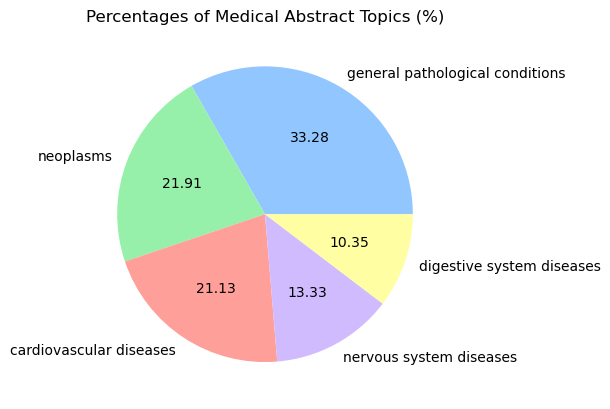

In [13]:
plt.style.use('seaborn-v0_8-pastel')
plt.pie(df_all['condition_name'].value_counts(), labels=list(df_all['condition_name'].value_counts().keys()), autopct='%.2f')
plt.title('Percentages of Medical Abstract Topics (%)')

In [14]:
# reading a random abstract from each of the 5 classes
for i, condition_name in enumerate(df_labels.condition_name):
    print(condition_name)
    abstract_list_for_specific_class = list(df_all[df_all.condition_label == i+1]['medical_abstract'])
    random_abstract_from_specific_class = random.choice(abstract_list_for_specific_class)
    print(random_abstract_from_specific_class)
    print('\n')

neoplasms
Incorporation of 12-methoxydodecanoate into the human immunodeficiency virus 1 gag polyprotein precursor inhibits its proteolytic processing and virus production in a chronically infected human lymphoid cell line. Covalent linkage of myristate (tetradecanoate; 14:0) to the NH2-terminal glycine residue of the human immunodeficiency virus 1 (HIV-1) 55-kDa gag polyprotein precursor (Pr55gag) is necessary for its proteolytic processing and viral assembly. We have shown recently that several analogs of myristate in which a methylene group is replaced by a single oxygen or sulfur atom are substrates for Saccharomyces cerevisiae and mammalian myristoyl-CoA:protein N-myristoyltransferase (EC 2.3.1.97; NMT) despite their reduced hydrophobicity. Some inhibit HIV-1 replication in acutely infected CD4+H9 cells without accompanying cellular toxicity. To examine the mechanism of their antiviral effects, we performed labeling studies with two analogs, 12-methoxydodecanoate (13-oxamyristate;

In [15]:
del df_train, df_test

In [16]:
# gonna add to this as I go
accuracy_for_all_models = {}

# Bag of Words

In [17]:
import nltk
from utils import visualization_utils

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm, decomposition, ensemble
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectPercentile

import torch

In [18]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

# for word lemmatization - helps reduce dimensionality and unnecessary differentiations between words with very similar meanings
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [19]:
# defining vectorizer
tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                                token_pattern=None,
                                strip_accents = 'unicode', 
                                stop_words = 'english', 
                                ngram_range = (1, 2),
                                lowercase = True, 
                                max_df = 0.5, 
                                min_df = 10) 

In [20]:
# vectorizing responses
x_train = tf_vectorizer.fit_transform(df_all[~df_all.test].medical_abstract).toarray()
x_test = tf_vectorizer.transform(df_all[df_all.test].medical_abstract).toarray()
assert len(x_train) + len(x_test) == len(df_all)

/Users/christian_g/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [21]:
x_train.shape

(11550, 23101)

In [22]:
# obtaining test and train inputs and labels
y_train = df_all[~df_all.test].condition_name
y_test = df_all[df_all.test].condition_name
assert len(x_train) == len(y_train) and len(x_test) == len(y_test)

In [23]:
# dimensionality reduction with singular value decomposition - from ~8000 features to 100; sparse --> dense representation
svd = decomposition.TruncatedSVD(n_components=100)

In [24]:
# dimensionality reduction with singular value decomposition
x_train_svd = svd.fit_transform(x_train)
x_test_svd = svd.transform(x_test)

<Axes: >

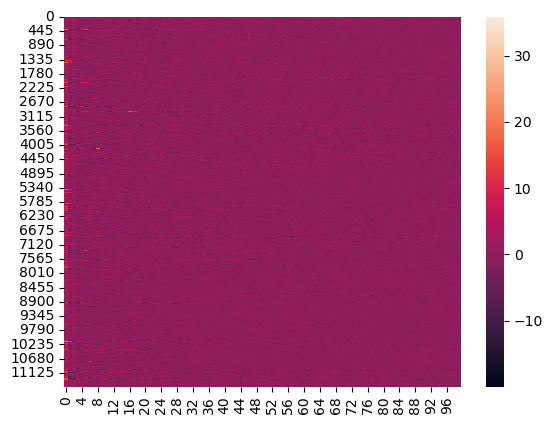

In [25]:
# visualizing variance in embeddings for training data 
sns.heatmap(x_train_svd)

In [26]:
del x_train, x_test

## Support Vector Machine

In [27]:
# support vector machine
model = svm.LinearSVC(dual='auto', max_iter=100_000)

In [28]:
model.fit(x_train_svd, y_train)

LinearSVC(dual='auto', max_iter=100000)

In [29]:
y_out = model.predict(x_test_svd)

In [30]:
accuracy = accuracy_score(y_out, y_test)
accuracy

0.5626731301939059

In [31]:
accuracy_for_all_models['BoW + SVC'] = accuracy

## Multiclass Logistic Regression

In [32]:
model = sklearn.linear_model.LogisticRegression(multi_class='multinomial')

In [33]:
model.fit(x_train_svd, y_train)

LogisticRegression(multi_class='multinomial')

In [34]:
y_out = model.predict(x_test_svd)

In [35]:
accuracy = accuracy_score(y_out, y_test)
accuracy

0.5626731301939059

In [36]:
accuracy_for_all_models['BoW + LR'] = accuracy

## Random Forest

In [37]:
model = ensemble.RandomForestClassifier()

In [38]:
model.fit(x_train_svd, y_train)

RandomForestClassifier()

In [39]:
y_out = model.predict(x_test_svd)

In [40]:
accuracy = accuracy_score(y_out, y_test)
accuracy

0.39162049861495846

In [41]:
accuracy_for_all_models['BoW + RF'] = accuracy

In [42]:
del x_train_svd, x_test_svd, y_train, y_test

# Word2Vec

In [192]:
import spacy
from utils import nlp_utils
import time

In [74]:
# spacy object to obtain word embeddings
nlp = spacy.load('en_core_web_md')

In [75]:
docs = [nlp(medical_abstract).vector for medical_abstract in tqdm(df_all.medical_abstract)]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 14438/14438 [12:45<00:00, 18.86it/s]


In [76]:
assert len(docs) == len(df_all.medical_abstract)

In [77]:
docs = np.array(docs)

In [78]:
# splitting train and test data
docs_train = docs[~df_all.test]
docs_test = docs[df_all.test]

In [79]:
docs_train.shape

(11550, 300)

In [137]:
# obtain labels for train and test data 
y_train = df_all[~df_all.test].condition_name
y_test = df_all[df_all.test].condition_name

In [81]:
assert len(y_train) == len(docs_train) and len(y_test) == len(docs_test)

In [82]:
del docs

In [104]:
def fit_and_test_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_out = model.predict(x_test)
    accuracy = accuracy_score(y_out, y_test)
    return accuracy

In [110]:
# defining models to be fit and tested
models = [svm.LinearSVC(dual='auto'), 
          sklearn.linear_model.LogisticRegression(multi_class='multinomial', max_iter=10_000), 
          ensemble.RandomForestClassifier()]

In [111]:
accuracy_list = []
for model in tqdm(models):
    accuracy = fit_and_test_model(model, docs_train, y_train, docs_test, y_test)
    accuracy_list.append(accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:42<00:00, 14.32s/it]


In [112]:
accuracy_list

[0.5609418282548476, 0.5450138504155124, 0.31024930747922436]

In [116]:
# adding accuracies to dict
model_names = ['Word2Vec + SVC', 'Word2Vec + LR', 'Word2Vec + RF']
for i, model_name in enumerate(model_names):
    accuracy_for_all_models[model_name] = accuracy_list[i]

In [124]:
del models, docs_train, docs_test, y_train, y_test

# Word2Vec - SciSpacy

In [125]:
# word vector library trained on biomedical data 
nlp = spacy.load('en_core_sci_md')

/Users/christian_g/anaconda3/envs/data_science/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_md' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [126]:
docs = [nlp(medical_abstract).vector for medical_abstract in tqdm(df_all.medical_abstract)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14438/14438 [14:14<00:00, 16.89it/s]


In [128]:
docs = np.array(docs)

In [129]:
docs.shape

(14438, 200)

In [131]:
del nlp

In [132]:
# splitting train and test data
docs_train = docs[~df_all.test]
docs_test = docs[df_all.test]

In [136]:
# obtain labels for train and test data
y_train = df_all[~df_all.test].condition_name
y_test = df_all[df_all.test].condition_name

In [133]:
del docs

In [134]:
# defining models to be fit and tested
models = [svm.LinearSVC(dual='auto'), 
          sklearn.linear_model.LogisticRegression(multi_class='multinomial', max_iter=10_000), 
          ensemble.RandomForestClassifier()]

In [138]:
accuracy_list = []
for model in tqdm(models):
    accuracy = fit_and_test_model(model, docs_train, y_train, docs_test, y_test)
    accuracy_list.append(accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.51s/it]


In [139]:
accuracy_list

[0.6142659279778393, 0.6063019390581718, 0.4362880886426593]

In [140]:
# adding accuracies to dict
model_names = ['Word2Vec (scipacy) + SVC', 'Word2Vec (scispacy) + LR', 'Word2Vec (Scispacy) + RF']
for i, model_name in enumerate(model_names):
    accuracy_for_all_models[model_name] = accuracy_list[i]

In [141]:
accuracy_for_all_models

{'BoW + SVC': 0.5626731301939059,
 'BoW + LR': 0.5626731301939059,
 'BoW + RF': 0.39162049861495846,
 'Word2Vec + SVC': 0.5609418282548476,
 'Word2Vec + LR': 0.5450138504155124,
 'Word2Vec + RF': 0.31024930747922436,
 'Word2Vec (scipacy) + SVC': 0.6142659279778393,
 'Word2Vec (scispacy) + LR': 0.6063019390581718,
 'Word2Vec (Scispacy) + RF': 0.4362880886426593}

In [154]:
del models, docs_train, docs_test, y_train, y_test

# SciSpacy Transformer

This package turned out to be a nightmare to try and use. I ended up creating a new environment for its transformer implementation, and
the code for that can be found in 'scispaCy_for_medical_abstract_classification.ipynb'

# Final Model Comparison

Text(0.5, 1.0, 'Comparison of Nautral Language Processing Techniques and Model Types \nfor Medical Abstract Topic Classification')

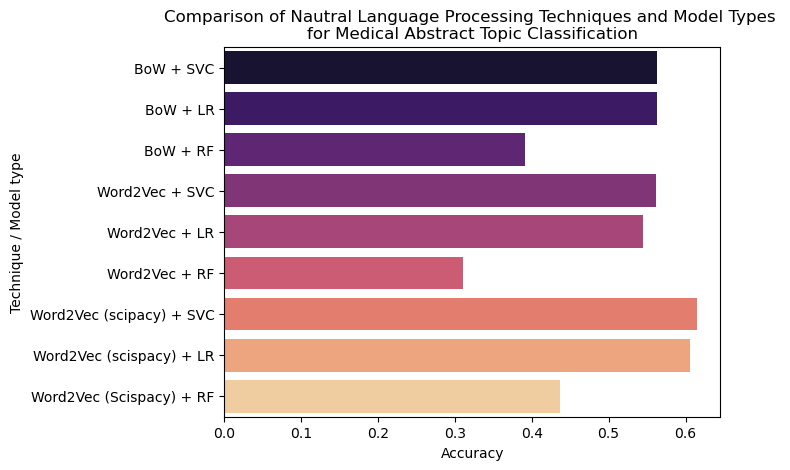

In [197]:
fig = sns.barplot(y=accuracy_for_all_models.keys(), x=accuracy_for_all_models.values(), orient='h', palette='magma', hue=accuracy_for_all_models.keys())
plt.xlabel('Accuracy')
plt.ylabel('Technique / Model type')
plt.title('Comparison of Nautral Language Processing Techniques and Model Types \nfor Medical Abstract Topic Classification')